In [52]:
%load_ext autoreload
%autoreload 1

import pandas as pd
import numpy as np

import os
import sys

from common import load_block_data_file_to_df

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
%aimport rebalance
%aimport common

DATA_PATH='../../data/oba_from_uniswap/instances-11827625-11874424'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
#df_exec_all = load_block_data_file_to_df('../../data/oba_from_uniswap/instances-11827625-11874424/per_block.json')
total_vol = df_exec_all.max_vol_usd.sum()
total_nr_trades = df_exec_all.shape[0]
total_nr_addresses = df_exec_all.address.nunique()
print("total_vol:", total_vol)
print("total_nr_trades:", total_nr_trades)
print("total_nr_addresses", total_nr_addresses)
vol_frac = df_exec_all.groupby('sell_token').max_vol_usd.sum() / total_vol
trades_frac = df_exec_all.groupby('sell_token').max_vol_usd.count() / total_nr_trades
addresses_frac = df_exec_all.groupby('sell_token').address.nunique() / total_nr_addresses
pd.concat([vol_frac.rename('volume'), trades_frac.rename('nr_trades'), addresses_frac.rename('nr_addresses')], axis=1).sort_values('volume', ascending=False).iloc[:30].to_clipboard()

total_vol: 1702752198.5142663
total_nr_trades: 244356
total_nr_addresses 90827


In [163]:
%autoreload
from common import get_dfs, compute_mean_gp_rel_surplus

def compute_stats(df_sol):
    nr_tokens=pd.concat([df_sol.sell_token, df_sol.buy_token], axis=0).nunique()
    nr_batches = df_sol.batch_start_time.nunique()
    nr_orders = df_sol.shape[0]
    total_savings_usd = df_sol.savings_vol_usd.sum()
    total_vol_usd = df_sol.max_vol_usd.sum()
    perc_rel_surplus_per_order = (compute_mean_gp_rel_surplus(df_sol) - 1)*100
    perc_abs_surplus_per_order_usd = (df_sol.savings_vol_usd/df_sol.max_vol_usd).mean()*100
    return pd.Series(
        [nr_tokens, nr_batches, nr_orders, total_savings_usd, total_vol_usd, perc_rel_surplus_per_order, perc_abs_surplus_per_order_usd],
        index=['nr_tokens', 'nr_batches','nr_orders','total_savings_usd','total_vol_usd','perc_rel_surplus_per_order','perc_abs_surplus_per_order_usd']
    )

df_sol, df_exec = get_dfs(f'{DATA_PATH}/random_sample-200', 60, 15, "0.99", "0.01")
compute_stats(df_sol)


nr_tokens                         1.500000e+01
nr_batches                        3.400000e+01
nr_orders                         1.320000e+02
total_savings_usd                 2.509034e+05
total_vol_usd                     1.542932e+06
perc_rel_surplus_per_order        3.285023e+01
perc_abs_surplus_per_order_usd    2.169034e+01
dtype: float64

In [157]:
df_exec_all = load_block_data_file_to_df(f'{DATA_PATH}/per_block.json')

batch_duration="60"
user_frac = "0.99"
limit_xrate_relax_frac = "0.01"

def resampled_stats(df_sol, nr_batches):
    batches = pd.Series(df_sol.batch_start_time.unique())
    r=[]
    for i in range(1000):
        sampled = batches.sample(nr_batches, replace=True)
        df = df_sol[df_sol.batch_start_time.isin(sampled)]
        r.append(compute_stats(df))
    return pd.DataFrame(r).median()

results=[]
for batch_duration in ["60"]:
    for user_frac in ["0.99"]: #,"0.99"
        for nr_tokens in [2, 3, 4, 5, 10, 15, 20, 30]:
            df_sol, df_exec = df_sol, df_exec = get_dfs(f'{DATA_PATH}/random_sample-1000', batch_duration, nr_tokens, user_frac, limit_xrate_relax_frac)
            df = resampled_stats(df_sol, 10)    # Necessary since number of batches is different for different parameter combinations
            df = compute_stats(df_sol)
            df['batch_duration'] = batch_duration
            df['user_frac'] = user_frac
            df['nr_tokens'] = nr_tokens
            #df['nr_users_unfiltered'] = compute_orig_total_users(df_sol, df_exec_all)
            #df['nr_orders_unfiltered'] = compute_orig_total_orders(df_sol, df_exec_all)
            results.append(df.rename(nr_tokens))
df=pd.concat(results, axis=1).transpose()

<AxesSubplot:title={'center':'Relative surplus (total)'}, xlabel='Number of tokens', ylabel='Saved vol / traded vol (%)'>

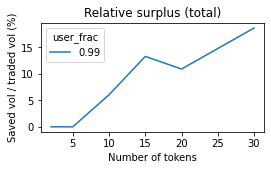

In [162]:
#(df.total_savings_usd/df.nr_batches).plot()
#(df.total_savings_usd/df.total_vol_usd).plot()
#(df.total_savings_usd/(df.total_vol_usd*0.003))

#df.pivot(columns="user_frac").perc_rel_surplus_per_order.plot()
#df[['nr_tokens','nr_batches','nr_orders','total_savings_usd','total_vol_usd']] #.to_clipboard()
#df['month_total_savings']=df.total_savings.
#df.pivot(columns="batch_duration").perc_abs_surplus_per_order_usd.plot(title="Surplus per order",xlabel="Number of tokens",ylabel="Surplus per order (%)", figsize=(4,2))
(df.pivot(columns="user_frac").total_savings_usd/df.pivot(columns="user_frac").total_vol_usd*100).plot(title="Relative surplus (total)",xlabel="Number of tokens",ylabel="Saved vol / traded vol (%)", figsize=(4,2))




surplus     0.188788
cum_frac    0.500391
dtype: float64

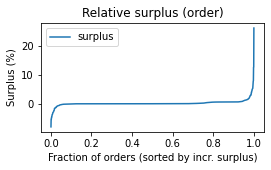

In [1202]:
df=((df_sol.surplus-1)*100).sort_values().to_frame()
df['cum_frac'] = (np.arange(1, df.shape[0]+1))/df.shape[0]
df.set_index("cum_frac").plot(title="Relative surplus (order)",xlabel="Fraction of orders (sorted by incr. surplus)",ylabel="Surplus (%)", figsize=(4,2))
df.mean()

In [1198]:
df

,nr_tokens,nr_batches,nr_orders,total_savings_usd,total_vol_usd,perc_rel_surplus_per_order,perc_abs_surplus_per_order_usd,batch_duration,user_frac,nr_users_unfiltered,nr_orders_unfiltered
2,2,28.0,56.0,195.812896,563826.720242,0.150526,0.150406,60,1,324,398
3,3,28.0,81.0,475.995286,1356811.646252,0.131138,0.130996,60,1,444,560
4,4,28.0,118.0,552.287806,1527215.165978,0.141395,0.141274,60,1,658,801
5,5,28.0,143.0,440.627634,1140370.723408,0.150657,0.150527,60,1,717,842
10,10,27.0,229.0,820.771512,1735948.762896,0.139515,0.139283,60,1,932,1117
15,15,27.0,299.0,866.370245,1443575.119336,0.178487,0.177915,60,1,1081,1282
20,20,26.0,310.0,990.470291,1600343.310923,0.155127,0.155253,60,1,964,1121
30,30,25.0,315.0,1482.1395,1663198.784909,0.138734,0.137174,60,1,817,947


In [62]:
from random import choice
from networkx import DiGraph, network_simplex
from scipy.stats import lomax, poisson
from math import log, exp

# Sample nr orders per batch.
def sample_nr_orders_per_batch(avg_nr_orders, nr_batches=1):

    #return poisson.rvs(avg_nr_orders, size=nr_batches) + 1

    # Use empirical distribution instead:
    s = df_sol.groupby('batch_start_time').block.count()
    dataset_avg_nr_orders = s.mean()
    s = (s * avg_nr_orders / dataset_avg_nr_orders).apply(lambda r: max(1, round(r)))
    return s.sample(n=nr_batches, replace=True).to_numpy()

# Sample order volumes.
def sample_order_vol(nr_orders=1):

    # Distribution parameters were fitted from data.
    #return lomax.rvs(c=0.932, scale=266.26, size=nr_orders)

    # Use empirical distribution instead:
    return df_sol.max_vol_usd.sample(n=nr_orders, replace=True)

# Estimates profit fraction when trading on GP vs trading on uniswap
# on a pair for which there is a pool.
def estimate_pair_improvement(avg_nr_orders, nr_batches = 10000):
    #total_surplus = 0
    total_log_surplus = 0
    nr_orders_batch = sample_nr_orders_per_batch(avg_nr_orders, nr_batches)
    total_nr_orders = sum(nr_orders_batch)
    order_sizes = sample_order_vol(total_nr_orders)
    order_j = 0
    for batch_i in range(nr_batches):
        x = 0
        y = 0
        for _ in range(nr_orders_batch[batch_i]):
            case = choice([0,1])
            if case == 0:
                x += order_sizes[order_j]
            else:
                y += order_sizes[order_j]
            order_j += 1

        # assume we can set price in [0.997, 1.003]*uni_xrate
        if x > 0 and y > 0:
            if x > y:
                unmatched_vol = max(0, x * 0.997 - y / 0.997)
                matched_vol = y / 0.997
            else:
                unmatched_vol = max(0, y * 0.997 - x / 0.997)
                matched_vol = x / 0.997
        else:
            unmatched_vol = abs(x-y)
            matched_vol = min(x, y)

        total_vol = 2 * matched_vol + unmatched_vol
        surplus = ((2 * matched_vol) * 1.003 + unmatched_vol) / total_vol
        log_surplus = log(surplus)
        #total_surplus += nr_orders_batch[batch_i] * surplus
        total_log_surplus += nr_orders_batch[batch_i] * log_surplus
    assert order_j == total_nr_orders
    #return total_surplus / total_nr_orders
    return exp(total_log_surplus / total_nr_orders)  - 1

# Estimates profit fraction when trading on GP vs trading on uniswap
# on a pair for which there is a pool.
def estimate_pair_volume_per_batch(avg_nr_orders, nr_batches = 10000):
    total_vol = []
    saved_vol = []
    v12s = []
    v21s = []
    nr_orders_batch = sample_nr_orders_per_batch(avg_nr_orders, nr_batches)
    total_nr_orders = sum(nr_orders_batch)
    order_sizes = sample_order_vol(total_nr_orders)
    order_j = 0
    for batch_i in range(nr_batches):
        v12 = 0
        v21 = 0
        for _ in range(nr_orders_batch[batch_i]):
            case = choice([0,1])
            if case == 0:
                v12 += order_sizes[order_j]
            else:
                v21 += order_sizes[order_j]
            order_j += 1

        # assume we can set price in [0.997, 1.003]*uni_xrate
        if v12 > 0 and v21 > 0:
            if v12 > v21:
                unmatched_vol = max(0, v12 * 0.997 - v21 / 0.997)
                matched_vol = v21 / 0.997
            else:
                unmatched_vol = max(0, v21 * 0.997 - v12 / 0.997)
                matched_vol = v12 / 0.997
        else:
            unmatched_vol = abs(v12 - v21)
            matched_vol = min(v12, v21)

        total_vol.append(2 * matched_vol + unmatched_vol)
        saved_vol.append((2 * matched_vol) * 0.003)
        v12s.append(v12)
        v21s.append(v21)

    assert order_j == total_nr_orders
    #return total_surplus / total_nr_orders
    return pd.concat([
        pd.Series(total_vol).rename('total_vol'),
        pd.Series(saved_vol).rename('saved_vol'),
        pd.Series(v12s).rename('v12'),
        pd.Series(v21s).rename('v21')
    ], axis=1)

def compute_pair_volume_per_batch(df):
    def compute_for_batch(df_batch):
        t1 = df_batch.iloc[0].sell_token
        t2 = df_batch.iloc[0].buy_token
        o12_df = df_batch[(df_batch.sell_token==t1)&(df.buy_token==t2)]
        o21_df = df_batch[(df_batch.sell_token==t2)&(df.buy_token==t1)]

        #v12 = o12_df.max_vol_usd.sum()
        #v21 = o21_df.max_vol_usd.sum()

        estim_xrate = pd.concat(
            [
                o12_df.exec_sell_amount_uni/o12_df.exec_buy_amount_uni,
                o21_df.exec_buy_amount_uni/o21_df.exec_sell_amount_uni
            ],
            axis=0
        ).mean()

        # p(t1)
        v12 = o12_df.max_vol_usd.sum()
        v21 = o21_df.max_vol_usd.sum() * estim_xrate

        # assume we can set price in [0.997, 1.003]*uni_xrate
        if v12 > 0 and v21 > 0:
            if v12 > v21:
                unmatched_vol = max(0, v12 - v21 * 1.006)
                matched_vol = v21 * 1.006
            else:
                unmatched_vol = max(0, v21 - v12 * 1.006)
                matched_vol = v12 * 1.006
        else:
            unmatched_vol = abs(v12 - v21)
            matched_vol = min(v12, v21)

        total_vol = v12 + v21 #2 * matched_vol + unmatched_vol
        saved_vol = (2 * matched_vol) * 0.003
        return pd.Series([total_vol, saved_vol, v12, v21])

    return df.groupby(['batch_start_time']).apply(compute_for_batch).rename(columns={0:'total_vol', 1:'saved_vol', 2:'v12', 3:'v21'})


# Estimates profit fraction when trading on GP vs trading on uniswap
# with multiple trading pairs.
# NOTE: assumes there is a pool for every token pair (i.e. no routing)
def estimate_improvement(nr_orders, nr_tokens, nr_samples = 10000):
    taxed_vol_gp = 0
    taxed_vol_uni = 0
    order_sizes = sample_order_vol(nr_samples * nr_orders)
    for i in range(0, nr_samples):
        total_sent_vol = {}
        for j in range(nr_orders):
            sell_token = choice(range(nr_tokens))
            buy_token = choice(range(nr_tokens - 1))
            if buy_token == sell_token: buy_token += 1
            sent_vol = order_sizes[i * nr_orders + j]
            if (sell_token, buy_token) in total_sent_vol.keys():
                total_sent_vol[sell_token, buy_token] += sent_vol
            else:
                total_sent_vol[sell_token, buy_token] = sent_vol
        
        matched_vol = compute_matched_vol(total_sent_vol)
        total_vol = sum(total_sent_vol.values())
        unmatched_vol = total_vol - matched_vol
        assert unmatched_vol >= 0

        taxed_vol_gp += unmatched_vol 
        taxed_vol_uni += total_vol

    taxed_vol_reduction = taxed_vol_gp/taxed_vol_uni
    return 0.003*(1 - taxed_vol_reduction)

In [25]:
from rebalance import compute_token_balance_delta_constant_buffers
compute_token_balance_delta_constant_buffers({(0,1):10, (1,0):10, (1,2):5, (2,1): 2}, {0: 1, 1: 0, 2: 2})

#compute_matched_vol_per_pair({(0,1):10, (1,0):10, (1,2):5, (2,1): 2})
#compute_token_balance_delta({(0,1):10, (1,0):10, (1,2):5, (2,1): 2})

#compute_token_balance_delta_constant_buffers({(0,1):10, (1,0):10, (1,2):5, (2,1): 2}, {0: 1, 1: 0, 2: 2})

#s={('FARM', 'WBTC'): 3307.385261238168, ('UNI', 'FARM'): 371.86397130752226, ('WETH', 'FARM'): 797.0731743335803, ('WETH', 'USDT'): 602.1090415509582}
#b={'WETH': 1000000, 'DAI': 0, 'USDT': 0, 'FARM': 0, 'LINK': 0, 'UNI': 0, 'AMPL': 0, 'YFI': 0, 'WBTC': 0, 'USDC': 0, 'CEL': 0, 'RAMP': 0, 'PICKLE': 0, 'KORE': 0, 'CORE': 0}
#compute_token_balance_delta_constant_buffers_simple(s,b)
compute_token_balance_delta_constant_buffers({(0,1):10, (1,0):10, (1,2):5, (2,1): 2}, {0: 1, 1: 0, 2: 2})

({1: 2.0, 0: 1, 2: 0}, 1)

In [140]:

%autoreload
from rebalance import compute_buffers_constant
from common import get_prices_at_blocks, get_block_data_file

def compute_rebalanced_volume(df, init_buffer_size, prices_in_eth):
    tokens = pd.concat([df.sell_token, df.buy_token]).unique()
    #buffers = {t: 0 for t in tokens}
    #buffers['WETH']=init_buffer_size
    buffers = {t: init_buffer_size/len(tokens) for t in tokens}
    #print(buffers)
    #compute_buffers_constant(df, buffers).rebalanced_vol.plot()
    buffers_across_time = compute_buffers_constant(df, buffers, prices_in_eth)
    vol_across_time = buffers_across_time.loc[:, buffers_across_time.columns != 'rebalanced_vol'].sum(axis=1)
    #vol_dev_across_time = abs(vol_across_time - init_buffer_size)
    #vol_dev_across_time_mean = vol_dev_across_time.mean()
    #vol_dev_across_time_max = vol_dev_across_time.max()
    final_vol = vol_across_time.iloc[-1]
    return buffers_across_time.rebalanced_vol.sum(), final_vol
    #, vol_dev_across_time_mean, vol_dev_across_time_max, final_vol

def compute_rebalances_table(df, prices_in_eth, min_init_buffer_size, max_init_buffer_size):
    geo_step = 1.2
    init_buffer_size = min_init_buffer_size
    r = []
    while init_buffer_size <= max_init_buffer_size:
        #rebalanced_vol, vol_dev_across_time_mean, vol_dev_across_time_max, final_vol = \
        rebalanced_vol, final_vol = \
            compute_rebalanced_volume(df, init_buffer_size, prices_in_eth)
        r.append({
            'init_buffer_size': init_buffer_size,
            'final_buffer_size': final_vol,
            'rebalanced_vol': rebalanced_vol,
            'impermanent_loss': init_buffer_size - final_vol 
            #'vol_dev_across_time_mean': vol_dev_across_time_mean, 
            #'vol_dev_across_time_max': vol_dev_across_time_max
        })
        init_buffer_size *= geo_step
    r_df = pd.DataFrame.from_records(r)
    r_df['total_vol'] = df.max_vol_eth.sum()
    r_df['rebalanced_frac'] = r_df.rebalanced_vol / r_df.total_vol
    return r_df

def filter_n_top_trading_tokens_by_volume(df, n):
    tokens = df.groupby('sell_token').max_vol_usd.sum().sort_values(ascending=False).iloc[:n]
    return df[df.sell_token.isin(tokens) & df.buy_token.isin(tokens)]

df_exec = get_block_data_file(f'{DATA_PATH}/random_sample-200', 60, 15, "0.99", "0.01")
tokens = pd.concat([df_exec.sell_token, df_exec.buy_token]).unique()
prices_in_eth = get_prices_at_blocks(DATA_PATH, df_exec.block.unique().tolist(), tokens)

df=df_exec
#df = filter_n_top_trading_tokens_by_volume(df_exec_all[df_exec_all.block.between(11827625, 11827625 + 15*4*60*24)], 15)
df['batch_start_time'] = df['timestamp'].floordiv(60)

price_eth = 1743
min_init_buffer_size = 1000 / price_eth
max_init_buffer_size = 10e6 / price_eth

df = compute_rebalances_table(df, prices_in_eth, min_init_buffer_size, max_init_buffer_size)


<AxesSubplot:title={'center':'Impermanent loss by buffer size'}, xlabel='Buffer size (USD)', ylabel='Impermanent loss (USD)'>

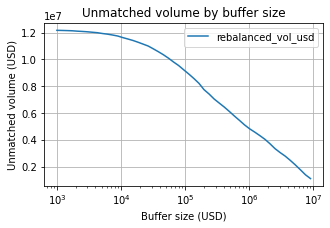

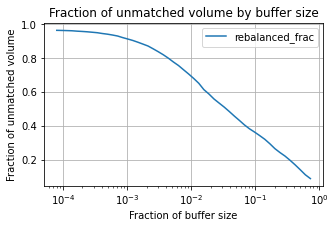

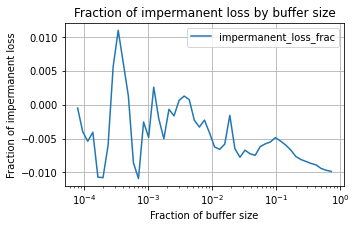

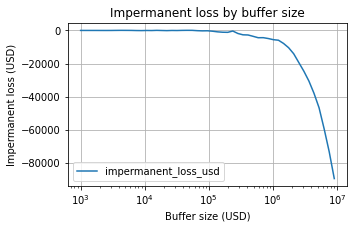

In [141]:
#df[['init_buffer_size','rebalanced_frac']].set_index("init_buffer_size").plot(title="Fraction of unmatched volume by buffer size",xlabel="Buffer size (USD)",ylabel="Fraction of unmatched volume", figsize=(4,2),logx=True)
df['init_buffer_size_usd'] = df['init_buffer_size'] * price_eth
df['rebalanced_vol_usd'] = df['rebalanced_vol'] * price_eth
df['impermanent_loss_usd'] = df['impermanent_loss'] * price_eth
df['total_vol_usd'] = df['total_vol'] * price_eth
df[['init_buffer_size_usd','rebalanced_vol_usd']].set_index("init_buffer_size_usd").plot(title="Unmatched volume by buffer size",xlabel="Buffer size (USD)",ylabel="Unmatched volume (USD)", figsize=(5,3),logx=True, grid=True)
df['init_buffer_size_frac'] = df.init_buffer_size / df.total_vol
df[['init_buffer_size_frac','rebalanced_frac']].set_index("init_buffer_size_frac").plot(title="Fraction of unmatched volume by buffer size",xlabel="Fraction of buffer size",ylabel="Fraction of unmatched volume", figsize=(5,3),logx=True, grid=True)
df['impermanent_loss_frac'] = df.impermanent_loss / df.init_buffer_size
df[['init_buffer_size_frac','impermanent_loss_frac']].set_index("init_buffer_size_frac").plot(title="Fraction of impermanent loss by buffer size",xlabel="Fraction of buffer size",ylabel="Fraction of impermanent loss", figsize=(5,3),logx=True, grid=True)

#compute_rebalanced_amount(df, 1e7, prices)
#df.groupby('batch_start_time').max_vol_usd.sum().max()
#df[['init_buffer_size', 'vol_dev_across_time_max']].set_index("init_buffer_size").plot()

"""
first_block=list(prices_in_eth.keys())[0]
last_block=list(prices_in_eth.keys())[-1]
init_vol = len(tokens)
init_amount = {t: 1/prices_in_eth[first_block][t] for t in tokens}
final_vol = sum(init_amount[t]*prices_in_eth[last_block][t] for t in tokens)
print(final_vol/init_vol)
"""

df[['init_buffer_size_usd','impermanent_loss_usd']].set_index("init_buffer_size_usd").plot(title="Impermanent loss by buffer size",xlabel="Buffer size (USD)",ylabel="Impermanent loss (USD)", figsize=(5,3),logx=True, grid=True)


In [36]:
# Compute optimal buffer size on hindsight, if never rebalancing.

def compute_balance_deltas(df_sol):
    balance_deltas = []
    def update_balances(batch_df):
        sent_vol = batch_df.groupby(["sell_token","buy_token"]).max_vol_usd.sum().to_dict()
        balance_delta = compute_token_balance_delta(sent_vol)
        balance_deltas.append(balance_delta)
    df_sol.groupby("batch_start_time").apply(update_balances)
    return pd.DataFrame.from_records(balance_deltas).fillna(0)

def compute_buffer_vol_boostrap(df_sol, nr_samples=1000):
    df_deltas = compute_balance_deltas(df_sol)
    r = []
    for i in range(nr_samples):
        buffer_vol=df_deltas.sample(frac=1).cumsum().min().clip(upper=0).abs().sum()
        r.append(buffer_vol)
    return pd.Series(r)

df = compute_buffer_vol_boostrap(df_sol)
(df.set_index('nr_batches').buffer_vol/df.set_index('nr_batches').total_vol).plot(title="Fraction of total traded volume in buffers",xlabel="Batches",ylabel="Min. fraction of traded vol in buffers", figsize=(4,2))



AttributeError: 'DataFrameGroupBy' object has no attribute 'set_index'

In [1189]:
# Fraction of trading volume required in buffers as a function of time between rebalances.

def compute_lp_fraction_per_nr_batches(df_sol):
    batches = pd.Series(df_sol.batch_start_time.unique())
    r = []
    for i in range(50, batches.shape[0],10):
        s_batches = batches.sample(i)
        df = df_sol[df_sol.batch_start_time.isin(s_batches)]
        m = compute_buffer_vol_boostrap(df).median()
        total_vol = df.max_vol_usd.sum()
        r.append(pd.Series([i, m, total_vol], index=['nr_batches','buffer_vol','total_vol']))
    return pd.DataFrame(r)

df=df_exec_all
df['batch_start_time'] = df.timestamp.floordiv(60)
df=compute_lp_fraction_per_nr_batches(df)

<AxesSubplot:title={'center':'Traded vol, buffer size per time'}, xlabel='Batches', ylabel='Volume USD'>

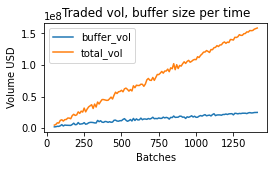

In [1195]:
#(df.set_index('nr_batches').buffer_vol/df.set_index('nr_batches').total_vol).plot(title="Fraction of total traded volume in buffers",xlabel="Batches",ylabel="Min. fraction of traded vol in buffers", figsize=(4,2))
#df=df_exec_all
#df['batch_start_time'] = df.timestamp.floordiv(60)
#compute_buffer_vol_boostrap(df).median()
#df.max_vol_usd.sum()
df.set_index('nr_batches').plot(title="Traded vol, buffer size per time",xlabel="Batches",ylabel="Volume USD", figsize=(4,2))

In [413]:
#df_sol[df_sol.batch_start_time==1603201258][['sell_token','buy_token','max_sell_amount','max_buy_amount', 'exec_sell_amount_uni','exec_buy_amount_uni','exec_sell_amount_gp','exec_buy_amount_gp','max_xrate','surplus','max_vol_usd','savings_vol_usd']].to_clipboard()
#df_exec[(df_exec.timestamp>=1603211184)&(df_exec.timestamp<=1603211227)].to_clipboard()

In [164]:
df_sol.surplus.sort_values()

block_index
11838760_127    0.952523
11827765_159    0.960098
11828476_77     0.980803
11834223_112    0.983143
11845357_22     0.990110
                  ...   
11847286_144    3.578000
11847537_48     3.942622
11847539_84     3.974276
11853887_166    3.980877
11848382_35     4.175255
Name: surplus, Length: 132, dtype: float64

<AxesSubplot:>

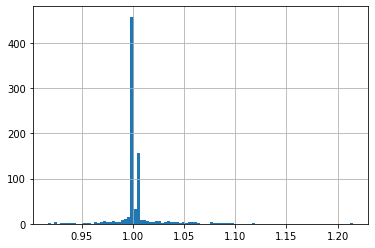

In [472]:
def compute_orig_batch_size(batchdf, df_exec):
    batch_start_time = batchdf.batch_start_time.iloc[0]
    batch_end_time = batchdf.batch_end_time.iloc[0]
    return ((df_exec.timestamp >= batch_start_time) & (df_exec.timestamp <= batch_end_time)).sum()

problem_batch_sizes = df_sol.groupby(['batch_start_time','batch_end_time']).apply(compute_orig_batch_size, df_exec=df_exec)
solution_batch_sizes = df_sol.groupby(['batch_start_time','batch_end_time']).count().block
batch_start_times = [b[0] for b in solution_batch_sizes[solution_batch_sizes==problem_batch_sizes].index]
df_sol[df_sol.batch_start_time.isin(batch_start_times)]

In [630]:
df_exec_all = load_block_data_file_to_df(f'{data_path}/../../per_block.json')

<AxesSubplot:title={'center':'Cumulative nr trades per distinct nr of addresses'}, xlabel='address fraction', ylabel='trade fraction'>

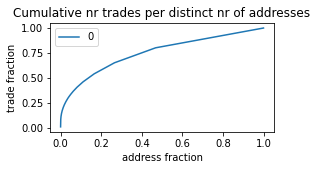

In [16]:
cs=(df_exec_all.value_counts('address')/df_exec_all.shape[0]).cumsum()
cs=cs.to_frame()
cs['wallet_frac']=np.arange(cs.shape[0])/cs.shape[0]
cs.set_index('wallet_frac').plot(xlabel='address fraction', ylabel='trade fraction',title='Cumulative nr trades per distinct nr of addresses',figsize=(4,2))

In [165]:
df_sol.loc["11848382_35"]

block                                                   11848382
index                                                         35
sell_token                                                  WETH
buy_token                                                    APY
max_buy_amount                                               NaN
max_sell_amount                                             20.0
sell_token_price_eth                                         1.0
buy_token_price_eth                                     0.000696
sell_token_price_usd                                 1800.671209
buy_token_price_usd                                     1.252778
timestamp                                             1613220857
exec_sell_amount_uni                                        20.0
exec_buy_amount_uni                                  6759.746774
nr_pools                                                       1
is_sell_order                                               True
address                 d

In [167]:
df_sol[df_sol.batch_start_time==1613220820][['sell_token','buy_token','max_sell_amount','max_buy_amount','exec_sell_amount_uni','exec_buy_amount_uni','xrate_uni','exec_sell_amount_gp','exec_buy_amount_gp','xrate_gp','surplus','max_vol_usd','savings_vol_usd','sell_reserve','buy_reserve']]#.to_clipboard()

,sell_token,buy_token,max_sell_amount,max_buy_amount,exec_sell_amount_uni,exec_buy_amount_uni,xrate_uni,exec_sell_amount_gp,exec_buy_amount_gp,xrate_gp,surplus,max_vol_usd,savings_vol_usd,sell_reserve,buy_reserve
block_index,,,,,,,,,,,,,,,
11848380_161,WETH,USDC,NaN,700.0,0.391103,700.000000,0.000559,0.391002,700.000000,0.000559,1.000259,702.138807,0.182674,8.769271e+04,1.575125e+08
11848380_5,WETH,USDC,25.0,NaN,25.000000,44757.230349,0.000559,25.000000,44756.823162,0.000559,0.999991,45016.780231,-0.408431,8.769271e+04,1.575125e+08
11848382_114,BADGER,WBTC,NaN,1.5,1047.644830,1.500000,698.429887,810.875963,1.500000,540.583976,1.291991,70268.747702,20426.633362,4.216083e+05,7.837594e+02
11848382_23,WETH,USDC,NaN,1030.0,0.575487,1030.000000,0.000559,0.575331,1030.000000,0.000559,1.000270,1033.169837,0.280190,8.771718e+04,1.574687e+08
11848382_35,WETH,APY,20.0,NaN,20.000000,6759.746774,0.002959,20.000000,28223.668561,0.000709,4.175255,36013.424185,26889.536515,1.288017e+03,1.851321e+06
11848384_115,USDC,WETH,297.0,NaN,297.000000,0.164949,1800.551655,297.000000,0.165896,1790.272926,1.005741,297.912027,1.705318,1.574669e+08,8.771815e+04


<AxesSubplot:title={'center':'Nr. of pairs with trades in both directions'}, xlabel='Number of tokens', ylabel='Number of pairs'>

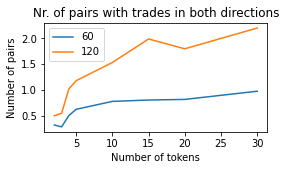

In [944]:

def nr_pairs_with_trades_in_both_direction(group_df):
    def has_trades_in_both_direction_token_pair(group_tp_df):
        t1 = group_tp_df.iloc[0].sell_token
        t2 = group_tp_df.iloc[0].buy_token
        t1t2 = group_tp_df[(group_tp_df.sell_token==t1)&(group_tp_df.buy_token==t2)]
        t2t1 = group_tp_df[(group_tp_df.sell_token==t2)&(group_tp_df.buy_token==t1)]
        return t1t2.shape[0]>0 and t2t1.shape[0]>0
    return group_df.groupby('token_pair').apply(has_trades_in_both_direction_token_pair).sum()

def compute_average_nr_pairs_with_trades_in_both_directions_per_batch(df_sol):
    return df_sol.groupby('batch_start_time').apply(nr_pairs_with_trades_in_both_direction).mean()

results=[]
for batch_duration in ['60','120']: #,'300']:
    results_per_batch_duration = []
    for nr_tokens in [2, 3, 4, 5, 10, 15, 20, 30]:
        df_sol, df_exec = get_dfs(batch_duration, nr_tokens, "0.99", "0.01")
        results_per_batch_duration.append(compute_average_nr_pairs_with_trades_in_both_directions_per_batch(df_sol))
    results.append(pd.Series(results_per_batch_duration, index=[2, 3, 4, 5, 10, 15, 20, 30]).rename(batch_duration))
pd.DataFrame(results).transpose().plot(title="Nr. of pairs with trades in both directions",xlabel="Number of tokens",ylabel="Number of pairs", figsize=(4,2))

<AxesSubplot:title={'center':'Number of pools used in most trades'}, xlabel='Cumulative fraction of number of trades', ylabel='Average number of pools used'>

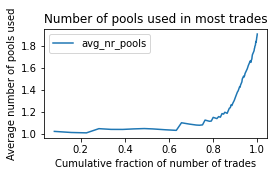

In [864]:
nr_pools_per_token_pair = df_exec.groupby('token_pair').nr_pools.mean()
vol_per_token_pair = df_exec.groupby('token_pair').max_vol_usd.sum()
nr_trades_per_token_pair = df_exec.groupby('token_pair').max_vol_usd.count().rename('nr_trades')
df=pd.concat([nr_pools_per_token_pair,vol_per_token_pair,nr_trades_per_token_pair], axis=1)
df['max_vol_usd_frac']=df.max_vol_usd/df.max_vol_usd.sum()
df['nr_trades_frac']=df.nr_trades/df.nr_trades.sum()
df=df.sort_values("nr_trades_frac",ascending=False)
df['cum_nr_trades_frac']=df.nr_trades_frac.cumsum()
df['avg_nr_pools']=df.nr_pools.cumsum()/np.arange(1, df.shape[0]+1)
df.plot(x='cum_nr_trades_frac', y='avg_nr_pools',xlabel='Cumulative fraction of number of trades',ylabel='Average number of pools used', title='Number of pools used in most trades', figsize=(4,2))

<AxesSubplot:title={'center':'Fraction of matched volume by nr tokens'}, xlabel='Number of tokens', ylabel='Fraction of matched volume'>

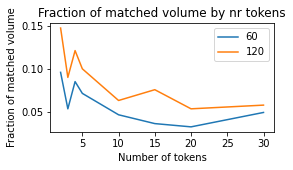

In [941]:
def compute_matched_vol_frac_per_batch(df_sol):
    def helper(batch_df):
        sent_vol = batch_df.apply(lambda r: ((r.sell_token, r.buy_token), r.max_vol_usd), axis=1)
        sent_vol = dict(sent_vol.to_dict().values())
        return compute_matched_vol(sent_vol)/sum(sent_vol.values())
    return df_sol.groupby('batch_start_time').apply(helper).mean()

results=[]
for batch_duration in ['60','120']:#,'300']:
    results_per_batch_duration = []
    for nr_tokens in [2, 3, 4, 5, 10, 15, 20, 30]:
        df_sol, df_exec = get_dfs(batch_duration, nr_tokens, "0.99", "0.01")
        results_per_batch_duration.append(compute_matched_vol_frac_per_batch(df_sol))
    results.append(pd.Series(results_per_batch_duration, index=[2, 3, 4, 5, 10, 15, 20, 30]).rename(batch_duration))
pd.DataFrame(results).transpose().plot(title="Fraction of matched volume by nr tokens",xlabel="Number of tokens",ylabel="Fraction of matched volume", figsize=(4,2))

<AxesSubplot:title={'center':'Volume per order'}, xlabel='Number of tokens', ylabel='Volume per order'>

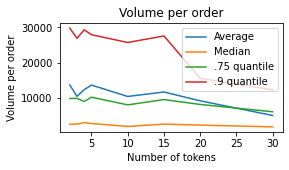

In [22]:
avgs=[]
medians=[]
q75=[]
q90=[]
batch_duration=60
fname='../../data/oba_from_uniswap/instances-11827625-11874424/random_sample-200'
for nr_tokens in [2, 3, 4, 5, 10, 15, 20, 30]:
    df_sol, df_exec = get_dfs(fname, batch_duration, nr_tokens, "0.99", "0.01")
    avgs.append(df_sol.max_vol_usd.mean())
    medians.append(df_sol.max_vol_usd.median())
    q75.append(df_sol.max_vol_usd.quantile(.75))
    q90.append(df_sol.max_vol_usd.quantile(.9))
df1=pd.Series(avgs, index=[2, 3, 4, 5, 10, 15, 20, 30]).rename("Average")
df2=pd.Series(medians, index=[2, 3, 4, 5, 10, 15, 20, 30]).rename("Median")
df3=pd.Series(q75, index=[2, 3, 4, 5, 10, 15, 20, 30]).rename(".75 quantile")
df4=pd.Series(q90, index=[2, 3, 4, 5, 10, 15, 20, 30]).rename(".9 quantile")
pd.concat([df1,df2,df3,df4], axis=1).plot(title="Volume per order",xlabel="Number of tokens",ylabel="Volume per order", figsize=(4,2))

<AxesSubplot:title={'center':'Fraction of matched volume by nr tokens'}, xlabel='Number of tokens', ylabel='Fraction of matched volume'>

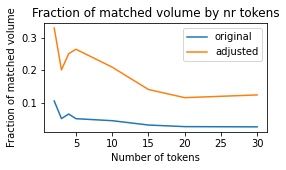

In [1247]:
def adjust_vol_distribution(df_sol):
    from scipy.stats import gamma
    vol_empirical_cdf=(df_sol.max_vol_usd.sort_values()/df_sol.max_vol_usd.sum()).cumsum()
    vol_adjusted=pd.Series(gamma.ppf(vol_empirical_cdf*0.9999, 9, 2), index=df_sol.index)
    return vol_adjusted

results=[]
for adjusted in [False, True]:
    results_per_adjusted = []
    for nr_tokens in [2, 3, 4, 5, 10, 15, 20, 30]:
        df_sol, df_exec = get_dfs(batch_duration, nr_tokens, "0.99", "0.01")
        if adjusted:
            df_sol.max_vol_usd = adjust_vol_distribution(df_sol)
        results_per_adjusted.append(compute_matched_vol_frac_per_batch(df_sol))
    results.append(pd.Series(results_per_adjusted, index=[2, 3, 4, 5, 10, 15, 20, 30]).rename("adjusted" if adjusted else "original"))
pd.DataFrame(results).transpose().plot(title="Fraction of matched volume by nr tokens",xlabel="Number of tokens",ylabel="Fraction of matched volume", figsize=(4,2))

#vol_adjusted.hist(bins=50)

<AxesSubplot:>

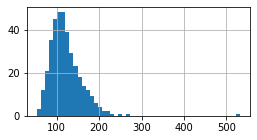

In [1255]:
df_sol, df_exec = get_dfs(batch_duration, 2, "0.99", "0.01")
#df_sol[df_sol.max_vol_usd<100000].max_vol_usd.hist(bins=50, figsize=(4,2))
(adjust_vol_distribution(df_sol)*20).hist(bins=50, figsize=(4,2))

In [134]:
%autoreload
from read_csv import read_swaps_from_csv
block_orders= read_swaps_from_csv("/home/marco/Downloads/swaps_data_from_router_11790000-11791000.csv", False)
orders= [o for orders in block_orders.values() for o in orders if {o['sellToken'], o['buyToken']}=={'0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2', '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48'}]

In [120]:
WETH="0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2"
total_amount_WETH = (sum(int(o['amounts'][0]) for o in orders if o['sellToken']==WETH) +
 sum(int(o['amounts'][1]) for o in orders if o['buyToken']==WETH))*1e-18
